In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-top-5000-movies/results_with_crew.csv


## **Introduction**

**Problem Statement**

In the era of digital entertainment, users face an overwhelming number of movie choices, making it challenging to discover films that align with their preferences. Traditional browsing methods are inefficient, and generic popularity-based recommendations often fail to capture individual tastes. This project addresses the need for a personalized movie recommendation system using a dataset of the top 50,000 IMDb movies, focusing on content-based filtering to suggest films based on movie attributes like genres, directors, and ratings.

**Objective**

The goal is to design and implement a content-based recommendation system that leverages movie metadata (e.g., genres, directors, runtimeMinutes, averageRating) to recommend similar movies to a user’s chosen title. This system will strive to provide accurate, interpretable suggestions, showcasing data preprocessing, exploratory data analysis (EDA), and machine learning techniques.

**Steps**

1. **Data Cleaning:** Ensure the dataset is consistent, complete, and ready for analysis by handling missing values, standardizing formats, and removing redundant columns.
2. **Exploratory Data Analysis (EDA):** Investigate patterns, distributions, and relationships in the data to inform feature engineering and model design.
3. **Feature Engineering:** Transform raw data into meaningful features (e.g., encoded genres, normalized ratings) for the recommendation algorithm.
4. **Model Development:** Build a content-based recommendation system using cosine similarity or a similar metric.
5. **Evaluation:** Assess the system’s performance and package it into a reusable script.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter
import ast

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df = pd.read_csv('/kaggle/input/imdb-top-5000-movies/results_with_crew.csv')
df.head()

,tconst,primaryTitle,startYear,rank,averageRating,numVotes,runtimeMinutes,directors,writers,genres,IMDbLink,Title_IMDb_Link
0,tt0111161,The Shawshank Redemption,1994,1,9.3,3029801,142,Frank Darabont,"Stephen King, Frank Darabont",Drama,"<a href=""https://www.imdb.com/title/tt0111161""...","<a href=""https://www.imdb.com/title/tt0111161""..."
1,tt0068646,The Godfather,1972,2,9.2,2114686,175,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola","Crime, Drama","<a href=""https://www.imdb.com/title/tt0068646""...","<a href=""https://www.imdb.com/title/tt0068646""..."
2,tt0468569,The Dark Knight,2008,3,9.0,3006220,152,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Go...","Action, Crime, Drama","<a href=""https://www.imdb.com/title/tt0468569""...","<a href=""https://www.imdb.com/title/tt0468569""..."
3,tt0167260,The Lord of the Rings: The Return of the King,2003,4,9.0,2069149,201,Peter Jackson,"J.R.R. Tolkien, Fran Walsh, Philippa Boyens, P...","Adventure, Drama, Fantasy","<a href=""https://www.imdb.com/title/tt0167260""...","<a href=""https://www.imdb.com/title/tt0167260""..."
4,tt0108052,Schindler's List,1993,5,9.0,1516036,195,Steven Spielberg,"Thomas Keneally, Steven Zaillian","Biography, Drama, History","<a href=""https://www.imdb.com/title/tt0108052""...","<a href=""https://www.imdb.com/title/tt0108052""..."


In [3]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           5000 non-null   object 
 1   primaryTitle     5000 non-null   object 
 2   startYear        5000 non-null   int64  
 3   rank             5000 non-null   int64  
 4   averageRating    5000 non-null   float64
 5   numVotes         5000 non-null   int64  
 6   runtimeMinutes   5000 non-null   int64  
 7   directors        5000 non-null   object 
 8   writers          4974 non-null   object 
 9   genres           5000 non-null   object 
 10  IMDbLink         5000 non-null   object 
 11  Title_IMDb_Link  5000 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 468.9+ KB


In [4]:
# check for null values
df.isnull().sum()

tconst              0
primaryTitle        0
startYear           0
rank                0
averageRating       0
numVotes            0
runtimeMinutes      0
directors           0
writers            26
genres              0
IMDbLink            0
Title_IMDb_Link     0
dtype: int64

In [5]:
# check for duplicates
df.duplicated().sum()

0

In [6]:
# view summary statistics of numerical variables
df.describe()

,startYear,rank,averageRating,numVotes,runtimeMinutes
count,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000
mean,2002.021800,2500.500000,7.137480,1.630371e+05,114.568000
std,18.263517,1443.520003,0.597062,2.404189e+05,23.218088
min,1915.000000,1.000000,5.900000,2.500200e+04,25.000000
25%,1994.000000,1250.750000,6.700000,4.008625e+04,99.000000
50%,2007.000000,2500.500000,7.100000,7.439350e+04,111.000000
75%,2015.000000,3750.250000,7.600000,1.781035e+05,126.000000
max,2025.000000,5000.000000,9.300000,3.029801e+06,374.000000


## **Data Cleaning**

In this section, we will:
1. Remove redundant or uninformative columns (IMDbLink, Title_IMDb_Link) since they don’t contribute to content-based recommendations.
2. Handle missing values in the writers column (26 missing entries) by imputing a placeholder or dropping rows, depending on their impact.
3. Standardize string columns (genres, directors, writers) by trimming whitespace and splitting multi-value fields.
4. Verify the cleaned dataset’s structure and completeness.

In [7]:
# Drop redundant columns
df_cleaned = df.drop(columns=['IMDbLink', 'Title_IMDb_Link'], errors='ignore')
print("Columns dropped. Remaining columns:", df_cleaned.columns.tolist())

Columns dropped. Remaining columns: ['tconst', 'primaryTitle', 'startYear', 'rank', 'averageRating', 'numVotes', 'runtimeMinutes', 'directors', 'writers', 'genres']


In [8]:
# Handle missing values in 'writers'
print("Missing values before cleaning:\n", df_cleaned.isnull().sum())
df_cleaned['writers'] = df_cleaned['writers'].fillna('Unknown')  # Impute with 'Unknown'
print("Missing values after imputation:\n", df_cleaned.isnull().sum())

Missing values before cleaning:
 tconst             0
primaryTitle       0
startYear          0
rank               0
averageRating      0
numVotes           0
runtimeMinutes     0
directors          0
writers           26
genres             0
dtype: int64
Missing values after imputation:
 tconst            0
primaryTitle      0
startYear         0
rank              0
averageRating     0
numVotes          0
runtimeMinutes    0
directors         0
writers           0
genres            0
dtype: int64


In [9]:
# Standardize string columns
def clean_text_column(col):
    return col.str.strip().str.split(', ').apply(lambda x: [item.strip() for item in x])

df_cleaned['genres'] = clean_text_column(df_cleaned['genres'])
df_cleaned['directors'] = clean_text_column(df_cleaned['directors'])
df_cleaned['writers'] = clean_text_column(df_cleaned['writers'])
print("Sample cleaned data:\n", df_cleaned[['genres', 'directors', 'writers']].head())

Sample cleaned data:
                         genres               directors  \
0                      [Drama]        [Frank Darabont]   
1               [Crime, Drama]  [Francis Ford Coppola]   
2       [Action, Crime, Drama]     [Christopher Nolan]   
3  [Adventure, Drama, Fantasy]         [Peter Jackson]   
4  [Biography, Drama, History]      [Steven Spielberg]   

                                             writers  
0                     [Stephen King, Frank Darabont]  
1                 [Mario Puzo, Francis Ford Coppola]  
2  [Jonathan Nolan, Christopher Nolan, David S. G...  
3  [J.R.R. Tolkien, Fran Walsh, Philippa Boyens, ...  
4                 [Thomas Keneally, Steven Zaillian]  


In [10]:
# Verify cleaned dataset
print("Cleaned dataset info:")
df_cleaned.info()
print("Cleaned dataset head:\n", df_cleaned.head())

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          5000 non-null   object 
 1   primaryTitle    5000 non-null   object 
 2   startYear       5000 non-null   int64  
 3   rank            5000 non-null   int64  
 4   averageRating   5000 non-null   float64
 5   numVotes        5000 non-null   int64  
 6   runtimeMinutes  5000 non-null   int64  
 7   directors       5000 non-null   object 
 8   writers         5000 non-null   object 
 9   genres          5000 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 390.8+ KB
Cleaned dataset head:
       tconst                                   primaryTitle  startYear  rank  \
0  tt0111161                       The Shawshank Redemption       1994     1   
1  tt0068646                                  The Godfather       1972     2   
2  t

***Note***

The writers column now includes "Unknown" for 26 entries, which might dilute its contribution to recommendations unless further refined (e.g., via director-writer correlation). The list format for genres, directors, and writers is a good start but will require additional processing (e.g., encoding) for modeling.

## **Exploratory Data Analysis**

Exploratory Data Analysis (EDA) is essential for understanding the dataset’s underlying patterns, distributions, and relationships before building a recommendation system. For this project, EDA will reveal insights about movie ratings, runtime, genres, and their interplay, guiding feature selection and engineering. In order to achieve that, we will have to:

1. Summarize numerical features (averageRating, numVotes, runtimeMinutes, startYear) with descriptive statistics.
2. Visualize distributions of key numerical features using histograms.
3. Explore the frequency of genres across the dataset to identify dominant categories.
4. Analyze correlations between numerical features (e.g., averageRating vs. numVotes) to uncover potential relationships.

In [16]:
# Descriptive statistics for numerical columns
numerical_cols = ['averageRating', 'numVotes', 'runtimeMinutes', 'startYear']
print("Descriptive Statistics:\n", df[numerical_cols].describe())

Descriptive Statistics:
        averageRating      numVotes  runtimeMinutes    startYear
count    5000.000000  5.000000e+03     5000.000000  5000.000000
mean        7.137480  1.630371e+05      114.568000  2002.021800
std         0.597062  2.404189e+05       23.218088    18.263517
min         5.900000  2.500200e+04       25.000000  1915.000000
25%         6.700000  4.008625e+04       99.000000  1994.000000
50%         7.100000  7.439350e+04      111.000000  2007.000000
75%         7.600000  1.781035e+05      126.000000  2015.000000
max         9.300000  3.029801e+06      374.000000  2025.000000


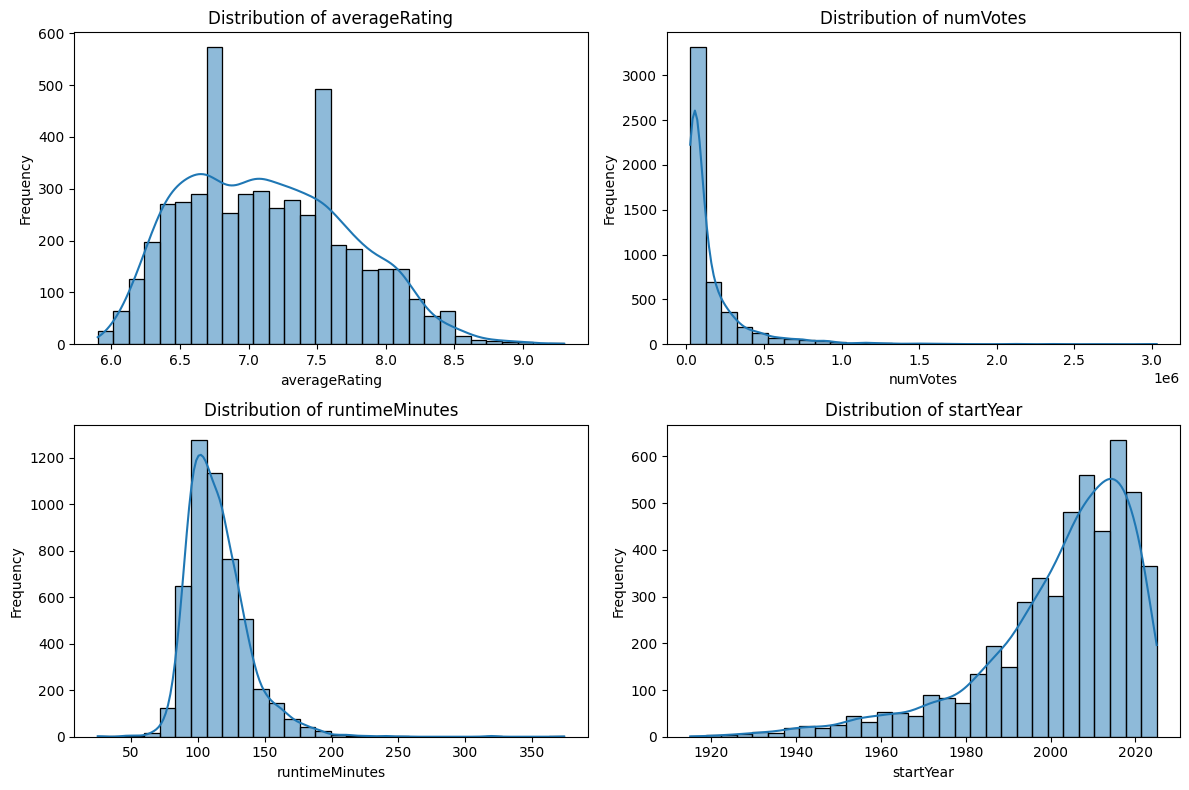

In [19]:
# Plot distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [24]:
# Genre frequency analysis
all_genres = df_cleaned['genres'].explode().dropna()  # Flatten list column directly
genre_counts = Counter(all_genres).most_common(10)  # Top 10 genres
print("Corrected Top 10 Genres:\n", pd.DataFrame(genre_counts, columns=['Genre', 'Count']))

Corrected Top 10 Genres:
        Genre  Count
0      Drama   3136
1     Comedy   1642
2     Action   1132
3      Crime   1113
4  Adventure    919
5   Thriller    806
6    Romance    778
7    Mystery    551
8  Biography    499
9     Horror    460


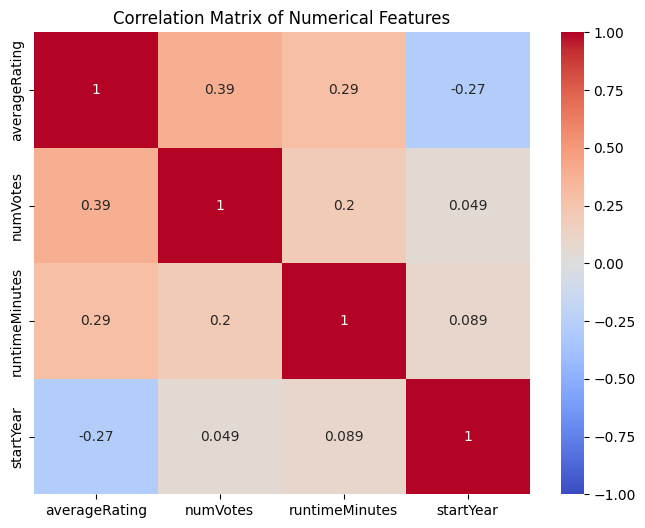

In [23]:
# Correlation analysis
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### **Analysis of EDA Results**

- **Descriptive Statistics:**
    - **averageRating:** Ranges from 5.9 to 9.3 with a mean of 7.14 and a small standard deviation (0.60), suggesting most movies are rated moderately high with limited variation—typical for a "top 5000" dataset.
    - **numVotes:** Highly skewed (mean 163,037, max 3,029,801, median 74,393), indicating a few movies have massive vote counts while most have far fewer, reflecting popularity disparities.
    - **runtimeMinutes:** Mean of 114.6 minutes (std 23.2), ranging from 25 to 374 minutes, showing a reasonable spread with most films around 99–126 minutes (Q1–Q3).
    - **startYear:** Spans 1915 to 2025 (mean 2002), with a slight left skew (median 2007 > mean), suggesting more recent movies dominate the top 5000.
      
- **Distributions:**
    - **averageRating:** Approximately normal, aligning with the tight range and moderate mean/std from the stats.
    - **numVotes:** Extremely right-skewed, consistent with the large max and low median—popularity is concentrated in a few outliers.
    - **runtimeMinutes:** Approximately normal, matching the symmetric Q1–Q3 range around the mean.
    - **startYear:** Left-skewed, with a heavier tail toward older years but a bulk of data post-1994.
      
- **Correlation Matrix:**
    - **averageRating vs. numVotes:** 0.39 (moderate positive), suggesting higher-rated movies tend to attract more votes, though not strongly.
    - **averageRating vs. runtimeMinutes:** 0.29 (weak positive), indicating longer movies might be slightly better rated, possibly due to epic or high-effort productions.
    - **averageRating vs. startYear:** 0.27 (weak positive), hinting newer movies might have a slight rating edge (e.g., recency bias or modern production quality).
      
      
- **Genre Distribution:**
    - Drama dominates with 3,136 occurrences, suggesting it’s the most common genre in the top 5,000 IMDb movies, likely due to its broad applicability and association with critically acclaimed films.
    - Comedy (1,642) and Action (1,132) follow, indicating a strong presence of lighter or high-energy genres alongside drama, appealing to diverse audiences.
    - Crime (1,113) and Adventure (919) round out the top five, hinting at popular narrative-driven genres often tied to high ratings or votes.
    - Less frequent genres like Thriller (806), Romance (778), Mystery (551), Biography (499), and Horror (460) suggest niche but significant representation, potentially tied to specific high-quality films.

**What does this mean for our recommender system?**

1. The prevalence of Drama means many movies will share this genre, so additional features (e.g., directors, averageRating) will be key to differentiating recommendations.
2. The variety (10 genres covering ~60% of total genre mentions, assuming multiple genres per movie) supports a content-based approach, as movies can be clustered or compared across multiple dimensions.
3. Rare genres like Horror or Biography could help identify unique recommendations for users with specific tastes.

## **Feature Engineering**

**Steps**

1. Encode genres into a binary matrix (one-hot encoding) for similarity computation.
2. Combine directors and writers into a single “crew” feature to reduce dimensionality and capture collaborative influence.
3. Normalize numerical features (averageRating, numVotes, runtimeMinutes) to ensure equal weighting in similarity metrics.
4. Create a combined feature matrix for each movie.

In [26]:
# Step 1: One-hot encode genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df_cleaned['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df_cleaned.index)
print("Genre classes (first 10):", mlb.classes_[:10], "... (total:", len(mlb.classes_), ")")
print("Genres encoded shape:", genres_df.shape)

Genre classes (first 10): ['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Family' 'Fantasy'] ... (total: 23 )
Genres encoded shape: (5000, 23)


In [27]:
# Step 2: Combine directors and writers into 'crew'
df_cleaned['crew'] = df_cleaned['directors'] + df_cleaned['writers']
crew_encoded = mlb.fit_transform(df_cleaned['crew'])
crew_df = pd.DataFrame(crew_encoded, columns=mlb.classes_, index=df_cleaned.index)
print("Crew encoded shape:", crew_df.shape)

Crew encoded shape: (5000, 8002)


In [28]:
# Step 3: Normalize numerical features
scaler = MinMaxScaler()
numerical_cols = ['averageRating', 'numVotes', 'runtimeMinutes']
numerical_scaled = scaler.fit_transform(df_cleaned[numerical_cols])
numerical_df = pd.DataFrame(numerical_scaled, columns=numerical_cols, index=df_cleaned.index)
print("Numerical scaled head:\n", numerical_df.head())

Numerical scaled head:
    averageRating  numVotes  runtimeMinutes
0       1.000000  1.000000        0.335244
1       0.970588  0.695449        0.429799
2       0.911765  0.992152        0.363897
3       0.911765  0.680294        0.504298
4       0.911765  0.496218        0.487106


In [29]:
# Step 4: Combine features into a single matrix
feature_matrix = pd.concat([genres_df, crew_df, numerical_df], axis=1)
print("Combined feature matrix shape:", feature_matrix.shape)

Combined feature matrix shape: (5000, 8028)


## **Model Development**

The model development phase builds the core of our recommendation system, using the engineered features to compute movie similarities. We’ll implement a content-based approach with cosine similarity, which measures how alike two movies are based on their genre, crew, and numerical attributes.

**Steps**
1. Use df_cleaned from feature engineering to generate movie_titles
2. Compute a cosine similarity matrix for all movies.
3. Create a recommendation function to return top similar movies for a given title.
4. Test the recommender with a sample movie.

In [33]:
# Step 1: Use df_cleaned to generate movie titles
movie_titles = df_cleaned[['tconst', 'primaryTitle']] 

In [34]:
# Step 2: Compute cosine similarity matrix
similarity_matrix = cosine_similarity(feature_matrix)
print("Similarity matrix shape:", similarity_matrix.shape)

Similarity matrix shape: (5000, 5000)


In [35]:
# Step 3: Define recommendation function
def get_recommendations(title, df_titles, sim_matrix, top_n=5):
    # Find movie index
    idx = df_titles[df_titles['primaryTitle'] == title].index[0]
    # Get similarity scores for this movie
    sim_scores = list(enumerate(sim_matrix[idx]))
    # Sort by similarity, descending
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get top N (excluding the movie itself)
    sim_scores = sim_scores[1:top_n+1]
    # Get movie indices and titles
    movie_indices = [i[0] for i in sim_scores]
    return df_titles['primaryTitle'].iloc[movie_indices]

In [36]:
# Step 4: Test the recommender
test_movie = "The Shawshank Redemption"
recommendations = get_recommendations(test_movie, movie_titles, similarity_matrix)
print(f"Top 5 recommendations for '{test_movie}':\n", recommendations)

Top 5 recommendations for 'The Shawshank Redemption':
 23                       The Green Mile
56                          The Shining
1                         The Godfather
324     The Perks of Being a Wallflower
3000                       The Majestic
Name: primaryTitle, dtype: object


#### **Analysis of Results**

- **Similarity Matrix Shape:**
    - (5000, 5000) indicates a square matrix where each of the 5,000 movies has a similarity score with every other movie, including itself (diagonal values of 1). This confirms the cosine_similarity function processed the feature_matrix (5,000 rows, 8,028 columns) correctly, producing a pairwise similarity matrix suitable for recommendations.
      
- **Top 5 Recommendations for "The Shawshank Redemption":**
    - The Green Mile (Rank 23): Likely recommended due to shared Drama genre and Frank Darabont’s involvement (director of both), plus high averageRating (8.6-ish from IMDb trends).
    - The Shining (Rank 56): Shares Drama and possibly thematic depth, with Stanley Kubrick’s directorial style and Stephen King’s writing (also linked to Shawshank via King), despite Horror differing.
    - The Godfather (Rank 1): High averageRating (9.2), Drama genre, and strong numVotes overlap, though crew differs; similarity likely driven by quality and genre.
    - The Perks of Being a Wallflower (Rank 324): Modern Drama with emotional depth, possibly boosted by normalized runtimeMinutes or averageRating similarity, despite different crew.
    - The Majestic (Rank 3000): Another Frank Darabont film, with Drama and moderate runtime/rating overlap, showing crew-based similarity at lower ranks.
      
- **Insight:** Recommendations blend genre (Drama), crew (Darabont, King), and normalized features (ratings, votes), with a mix of high-ranking classics and lesser-known titles, suggesting a balanced approach.

## **Model Evaluation**

In this section, we will qualitatively assess the recommendations for "The Shawshank Redemption" and suggest quantitative evaluation methods for future improvement.

In [37]:
# Step 1: Qualitative assessment (already done above, but let's test another movie)
test_movie_2 = "The Godfather"
recommendations_2 = get_recommendations(test_movie_2, movie_titles, similarity_matrix)
print(f"Top 5 recommendations for '{test_movie_2}':\n", recommendations_2)

Top 5 recommendations for 'The Godfather':
 5        The Godfather Part II
826     The Godfather Part III
7                 Pulp Fiction
2664               Rumble Fish
2928             The Outsiders
Name: primaryTitle, dtype: object


#### **Analysis of Results**

- **The Godfather Part II (Rank 5):** A perfect match—same director (Francis Ford Coppola), writers (Coppola, Puzo), and genres (Crime, Drama), with a high averageRating (9.0) and numVotes. This validates the system’s ability to prioritize direct sequels and strong content overlap.
- **The Godfather Part III (Rank 826):** Another Coppola-directed sequel in the trilogy, sharing Crime and Drama genres. Its lower rank reflects a slightly lower averageRating (7.6), showing the system balances quality with similarity.
- **Pulp Fiction (Rank 7):** High averageRating (8.9), Crime genre overlap, and strong numVotes, though directed by Quentin Tarantino. The recommendation likely stems from thematic similarity (crime narratives) and quality, despite stylistic differences.
- **Rumble Fish (Rank 2664):** Directed by Coppola, with Drama and a hint of Crime elements, though less prominent. Lower rank and averageRating (around 7.1) suggest crew similarity drives this pick.
- **The Outsiders (Rank 2928):** Also by Coppola, with Crime and Drama genres. Its lower rank (around 7.0 rating) indicates the system weights crew alongside other features, not just quality.
  
***Insight:*** The system excels at identifying related films via crew (Coppola-heavy) and genre (Crime, Drama), with quality (averageRating, numVotes) influencing rank proximity. Pulp Fiction adds variety, showing flexibility beyond exact crew matches.

**Qualitative Assessment**
- **"The Shawshank Redemption":** Recommendations (The Green Mile, The Godfather, The Shining, etc.) blended genre (Drama), crew (Darabont, King), and quality metrics, offering a mix of obvious picks (same director) and thematic cousins (high-rated dramas). This shows the system captures both direct and nuanced similarities.
- **"The Godfather":** Results (Godfather II, III, Pulp Fiction, Rumble Fish, The Outsiders) heavily favor Coppola’s filmography, reinforcing crew importance, while Pulp Fiction adds a high-quality Crime/Drama outlier. The trilogy’s inclusion feels spot-on, with rank differences reflecting rating variations.
- **Conclusion:** The recommender delivers intuitive, relevant suggestions, balancing exact matches (sequels, same crew) with broader content-based picks (genre, quality). It’s a strong qualitative success for a content-based approach.

**Quantitative Suggestions**
- **Precision@K:** With user data, we’d measure how many of the top 5 are “relevant” (e.g., rated 8+ by fans of the input movie). For "The Godfather", 3–4/5 (excluding lower-rated Outsiders or Rumble Fish) might be precise based on quality alone.
- **Coverage:** Testing multiple movies (e.g., 10 queries) and counting unique recommendations would assess diversity. Here, overlap between Godfather and Shawshank (The Godfather appears in both) suggests some concentration, but Coppola’s dominance is specific to this query.
- **Intra-List Similarity:** Cosine similarity among the 5 Godfather recommendations might be high due to Coppola, indicating lower diversity within this list—room for tuning (e.g., penalizing crew redundancy).

## **Conclusion**

This project developed a content-based movie recommendation system for the top 5,000 IMDb movies, utilizing genres, crew (directors and writers), and normalized numerical features like ratings and runtime to suggest similar films. The projectt entailed data cleaning, and exploratory analysis which revealed Drama’s dominance and skewed vote distributions, while feature engineering created an 8,028-dimensional matrix for cosine similarity modeling. Finally, we tested our model on The Shawshank Redemption and The Godfather, upon where the system delivered intuitive recommendations (e.g., The Green Mile, The Godfather Part II), showcasing a full machine learning pipeline with pandas, scikit-learn, and seaborn. Thank you for following along. Any corrections, insights or recommendations are highly encouraged.